In [67]:
import tushare as ts
import seaborn as sns
import keras
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats
from keras.models import Model
from keras import backend as K
from keras.layers import Input, Dense, LSTM, Dropout, Bidirectional, BatchNormalization, Activation
from keras.callbacks import EarlyStopping, TensorBoard
from keras.optimizers import RMSprop, Adam
from keras.initializers import Orthogonal
from tcn import TCN
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import (
    roc_auc_score, roc_curve, auc, f1_score,
    confusion_matrix, recall_score, 
    precision_recall_fscore_support)
set_matplotlib_formats('retina')

In [2]:
use = ['Symbol', 'ContrshrProportion', 'IsRelatedTrading', 'ShareholderFirstProp',
       'ControlProportion', 'FamEntyp_1.0', 'FamEntyp_2.0', 'FamEntyp_3.0',
       'BoardCode_P3401', 'BoardCode_P3402', 'BoardCode_P3403', 'FamStyle_1',
       'FamStyle_2', 'ManGeneration_1.0', 'ManGeneration_2.0',
       'FamNameStatus_1', 'FamNameStatus_2', 'FamNameStatus_3',
       'FamNameStatus_4', 'FamNameStatus_5']
fam = pd.read_csv('../data/family_firm_clean.csv', index_col=0, usecols=use)

In [3]:
pledge_neg = pd.read_csv('../data/pledge/pledge_company_neg.csv', 
                         parse_dates=['start_date'])
pledge_pos = pd.read_csv('../data/pledge/pledge_company_pos.csv',
                        parse_dates=['start_date', 'close_date'])

In [4]:
pledge_neg = pledge_neg.sort_values(by=['start_date'])
pledge_neg = pledge_neg.reset_index(drop=True)

In [5]:
pledge_pos = pledge_pos.sort_values(by=['start_date'])
pledge_pos = pledge_pos.reset_index(drop=True)

In [6]:
pledge_pos.shape

(15891, 30)

In [7]:
pledge_neg.shape

(19753, 29)

In [8]:
pledge_neg = pledge_neg.merge(fam, how='left', left_on='ts_code', right_on='Symbol')
pledge_neg = pledge_neg.fillna(0)

In [9]:
pledge_pos = pledge_pos.merge(fam, how='left', left_on='ts_code', right_on='Symbol')
pledge_pos = pledge_pos.fillna(0)

In [10]:
pledge_neg.head(10)

,ts_code,start_date,pledge_price,forcast_close_line,is_reach_close_line,current_ratio,quick_ratio,cash_ratio,inv_turn,ar_turn,...,BoardCode_P3403,FamStyle_1,FamStyle_2,ManGeneration_1.0,ManGeneration_2.0,FamNameStatus_1,FamNameStatus_2,FamNameStatus_3,FamNameStatus_4,FamNameStatus_5
0,600998.SH,2016-01-04,17.4032,12.18224,False,1.3862,1.0302,0.9365,1.7793,1.5325,...,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0
1,300071.SZ,2016-01-04,12.6686,8.86802,False,1.2334,1.2334,1.1324,0.0000,0.7313,...,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0
2,300409.SZ,2016-01-04,14.3533,10.04731,False,3.5132,2.8557,2.8079,0.2906,0.4558,...,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0
3,002706.SZ,2016-01-04,8.1208,5.68456,False,3.9828,3.4084,2.9236,0.9005,2.7326,...,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0
4,300203.SZ,2016-01-04,29.7155,20.80085,False,1.6633,1.3274,1.2020,0.2894,0.2386,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
5,000603.SZ,2016-01-04,15.8926,11.12482,False,0.7487,0.6943,0.6544,0.7073,63.7869,...,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0
6,000401.SZ,2016-01-04,9.5732,6.70124,False,0.4462,0.3766,0.2715,0.9737,0.9353,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,600189.SH,2016-01-04,8.8649,6.20543,False,0.8507,0.7656,0.5832,0.2099,1.4492,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,000686.SZ,2016-01-04,14.1314,9.89198,False,1.4414,1.4414,0.0000,0.0000,0.0000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,002729.SZ,2016-01-05,62.5638,43.79466,False,8.5209,7.0754,4.3068,0.5076,1.0151,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0


In [11]:
pledge_neg.shape

(19753, 48)

In [12]:
pledge_pos.shape

(15891, 49)

In [13]:
codes = set(pd.read_csv('../data/pledge/pledge_full_clean.csv')['ts_code'])
code_price_dict = dict()
for code in codes:
    price_df = pd.read_csv('../data/price/{}.csv'.format(code), index_col=0)
    price_df.index = pd.to_datetime(price_df.index)
    code_price_dict[code] = price_df

In [56]:
def get_stock_price_by_pos_code(code, lookback, 
                                delay, pledge_date, 
                                close_position_date, 
                                code_price_dict, pledge_price):
    """
    通过爆仓股票代码，过去天数，生成三维的股票价格矩阵
    delay * lookback * 9(features)
    """
    scaler = MinMaxScaler()
    non_close_rate = 4
    step = 4
    price_df = code_price_dict[code]
    price_df = price_df.drop(['pre_close'], axis=1)
    price_df['delta'] = price_df.apply(lambda x: x['close'] - pledge_price, axis=1)
    price_df = price_df[pledge_date: close_position_date]
    price_values = scaler.fit_transform(price_df)
    # 平仓训练集
    usable_close_len = len(price_df) - lookback
    usable_close_len = min(usable_close_len, delay + 1)
    close_list = []
    for i in range(1, usable_close_len + 1, step):
        price_time = price_values[-lookback - i: -i]
        close_list.append(price_time)
    # 正常训练集
    usable_non_close_len = len(price_df) - delay - lookback
    usable_non_close_len = min(usable_non_close_len, non_close_rate * delay)
    non_close_list = []
    for i in range(delay+1, delay+1+usable_non_close_len, step):
        price_time = price_values[-lookback - i: -i]
        non_close_list.append(price_time)
        
    return close_list, non_close_list

In [57]:
def get_stock_price_by_neg_code(code, delay, lookback, pledge_date, code_price_dict, pledge_price):
    """
    通过非爆仓股票代码，过去天数，生成三维的股票价格矩阵
    delay * lookback * 9(features)
    """
    scaler = MinMaxScaler()
    step = 4
    price_df = code_price_dict[code]
    price_df = price_df.drop(['pre_close'], axis=1)
    price_df['delta'] = price_df.apply(lambda x: x['close'] - pledge_price, axis=1)
    price_df = price_df[:pledge_date]
    price_values = scaler.fit_transform(price_df)
    # 质押前训练集
    usable_close_len = len(price_df) - lookback
    usable_close_len = min(usable_close_len, delay + 1)
    price_list = []
    for i in range(1, usable_close_len + 1, step):
        price_time = price_values[-lookback - i: -i]
        price_list.append(price_time)
        
    return price_list

In [16]:
def pos_generator(pledge, lookback, delay, min_index, max_index, code_price_dict):
    # batch_size == delay(30)
    i = min_index
    all_zip = []
    # 归一化
    scaler = MinMaxScaler()
    pledge_scaled = pledge.drop(['ts_code', 'start_date', 'close_date'], axis=1)
    pledge_scaled = scaler.fit_transform(pledge_scaled)
    while i < max_index:
        single_pledge = pledge.loc[i]
        single_pledge_scaled = pledge_scaled[i]
        close_list, non_close_list = get_stock_price_by_pos_code(code=single_pledge['ts_code'],
                               lookback=lookback,
                               delay=delay,
                               pledge_date=single_pledge['start_date'],
                               close_position_date=single_pledge['close_date'],
                               code_price_dict=code_price_dict,
                               pledge_price=single_pledge['pledge_price'])
        close_zip = [(prices, single_pledge_scaled, 1) for prices in close_list]
        non_close_zip = [(prices, single_pledge_scaled, 0) for prices in non_close_list]
        all_zip += close_zip + non_close_zip
        i += 1
    return all_zip

In [17]:
def neg_generator(pledge, lookback, delay, min_index, max_index, code_price_dict):
    # batch_size == delay(30)
    i = min_index
    all_zip = []
    # 归一化
    scaler = MinMaxScaler()
    pledge_scaled = pledge.drop(['ts_code', 'start_date'], axis=1)
    pledge_scaled = scaler.fit_transform(pledge_scaled)
    while i < max_index:
        single_pledge = pledge.loc[i]
        single_pledge_scaled = pledge_scaled[i]
        price_list = get_stock_price_by_neg_code(code=single_pledge['ts_code'],
                               lookback=lookback,
                               delay=delay,
                               pledge_date=single_pledge['start_date'],
                               code_price_dict=code_price_dict,
                               pledge_price=single_pledge['pledge_price'])
        all_zip += [(prices, single_pledge_scaled, 0) for prices in price_list]
        i += 1
    return all_zip

In [18]:
print('neg: {}  pos: {}'.format(len(pledge_neg), len(pledge_pos)))

neg: 19753  pos: 15891


In [58]:
lookback = 48
delay = 30
train_neg_num = int(len(pledge_neg) * 0.8)
train_pos_num = int(len(pledge_pos) * 0.8)

train_zip = neg_generator(pledge_neg, lookback, delay, 0, train_neg_num, code_price_dict) + pos_generator(pledge_pos, lookback, delay, 0, train_pos_num, code_price_dict)
test_zip = neg_generator(pledge_neg, lookback, delay, train_neg_num, len(pledge_neg), code_price_dict) + pos_generator(pledge_pos, lookback, delay, train_pos_num, len(pledge_pos), code_price_dict)

In [59]:
def get_price_info_target_by_zip(all_zip):
    random.shuffle(all_zip)
    price_time = np.stack([t[0] for t in all_zip])
    pledge_info = np.stack([t[1] for t in all_zip])
    targets = np.stack([t[2] for t in all_zip])
    return price_time, pledge_info, targets

In [60]:
train_price, train_info, train_target = get_price_info_target_by_zip(train_zip)
test_price, test_info, test_target = get_price_info_target_by_zip(test_zip)

In [61]:
train_info.shape

(442680, 46)

In [62]:
train_price.shape

(442680, 48, 9)

In [26]:
def show_ratio(target):
    unique, counts = np.unique(target, return_counts=True)
    d = dict(zip(unique, counts))
    print(d)
    print(d[0] / (d[0] + d[1]))
    return d[0] / d[1]

In [63]:
weight_1 = show_ratio(train_target)

{0: 350724, 1: 91956}
0.7922743290864733


In [64]:
show_ratio(test_target)

{0: 50041, 1: 16210}
0.7553244479328614


3.087045033929673

In [65]:
weight_1

3.8140414981077906

In [43]:
def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [68]:
def get_model(time_steps, price_dim, info_dim):
    price_input = Input(shape=(time_steps, price_dim), name='price_input')
    
#     lstm_out = Bidirectional(LSTM(16, 
#                     dropout=0.2,
#                     recurrent_dropout=0.5, 
#                     kernel_initializer=Orthogonal(seed=7),
#                     return_sequences=False
#                    ))(price_input)
    tcn_out = TCN(nb_filters=64, 
            kernel_size=3, 
            dilations=[1, 2, 4, 8, 16], 
            nb_stacks=1, 
            dropout_rate=0.3,
            kernel_initializer=Orthogonal(seed=7),
            return_sequences=False)(price_input)
#     price_con = keras.layers.concatenate([lstm_out, tcn_out])
#     price_out = Dense(16, activation='relu')(price_con)
#     price_out = Dropout(0.3)(price_out)
    
    info_input = Input(shape=(info_dim,), name='info_input')
    x = keras.layers.concatenate([tcn_out, info_input])
    
    x_1 = Dense(128, activation='relu')(x)
    x = Dense(128, activation='relu')(x_1)
    x = Dense(128, activation='relu')(x)
    x = keras.layers.add([x, x_1])
    
    x = Dropout(0.2)(x)
    x = BatchNormalization()(x)
    
    x_2 = Dense(512, activation='relu')(x)
    x = Dense(512, activation='relu')(x_2)
    x = keras.layers.add([x, x_2])
    
    x = Dropout(0.2)(x)
    x = BatchNormalization()(x)
    
    x_3 = Dense(128, activation='relu')(x)
    x = Dense(128, activation='relu')(x_3)
    x = keras.layers.add([x, x_3])
    
    x = Dropout(0.2)(x)
    x = BatchNormalization()(x)

    x = Dense(32, activation='sigmoid')(x)
    output = Dense(1, activation='sigmoid', name='output')(x)
    
    model = Model(inputs=[price_input, info_input], outputs=[output])
    return model

In [69]:
model = get_model(time_steps=lookback, price_dim=train_price.shape[-1], info_dim=train_info.shape[-1])
model.compile(optimizer=Adam(), 
              loss='binary_crossentropy', 
              metrics=['accuracy', f1])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
price_input (InputLayer)        (None, 48, 9)        0                                            
__________________________________________________________________________________________________
conv1d_129 (Conv1D)             (None, 48, 64)       640         price_input[0][0]                
__________________________________________________________________________________________________
conv1d_130 (Conv1D)             (None, 48, 64)       12352       conv1d_129[0][0]                 
__________________________________________________________________________________________________
activation_121 (Activation)     (None, 48, 64)       0           conv1d_130[0][0]                 
__________________________________________________________________________________________________
spatial_dr

In [70]:
class_weight = {
    0: 1,
    1: weight_1
}

tbCallBack = TensorBoard(log_dir='./logs')
early_stop = EarlyStopping(monitor='val_f1', patience=2, mode='max')
history = model.fit([train_price, train_info], 
          train_target, 
          epochs=10, 
          batch_size=128,
          callbacks=[tbCallBack, early_stop],
          validation_data=([test_price, test_info], test_target),
#           class_weight=class_weight
)

Train on 442680 samples, validate on 66251 samples


W0907 17:36:33.761517 13068 deprecation_wrapper.py:119] From C:\Users\A\Anaconda3\envs\keras_tf\lib\site-packages\keras\callbacks.py:850: The name tf.summary.merge_all is deprecated. Please use tf.compat.v1.summary.merge_all instead.

W0907 17:36:33.762514 13068 deprecation_wrapper.py:119] From C:\Users\A\Anaconda3\envs\keras_tf\lib\site-packages\keras\callbacks.py:853: The name tf.summary.FileWriter is deprecated. Please use tf.compat.v1.summary.FileWriter instead.



Epoch 1/10
442680/442680 [==============================] - 87s 196us/step - loss: 0.3650 - acc: 0.8340 - f1: 0.5096 - val_loss: 0.3196 - val_acc: 0.8453 - val_f1: 0.5854
Epoch 2/10
442680/442680 [==============================] - 84s 191us/step - loss: 0.3414 - acc: 0.8470 - f1: 0.5534 - val_loss: 0.2664 - val_acc: 0.8699 - val_f1: 0.7132
Epoch 3/10
442680/442680 [==============================] - 85s 191us/step - loss: 0.3280 - acc: 0.8542 - f1: 0.5813 - val_loss: 0.2770 - val_acc: 0.8613 - val_f1: 0.6485
Epoch 4/10
442680/442680 [==============================] - 85s 191us/step - loss: 0.3180 - acc: 0.8596 - f1: 0.6015 - val_loss: 0.2545 - val_acc: 0.8793 - val_f1: 0.7312
Epoch 5/10
442680/442680 [==============================] - 84s 191us/step - loss: 0.3102 - acc: 0.8641 - f1: 0.6184 - val_loss: 0.2779 - val_acc: 0.8720 - val_f1: 0.6873
Epoch 6/10
442680/442680 [==============================] - 84s 190us/step - loss: 0.3033 - acc: 0.8679 - f1: 0.6298 - val_loss: 0.2546 - val_acc

In [71]:
def plot_loss(history, title):
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(loss))

    plt.figure()

    plt.plot(epochs, loss, 'r', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title(title)
    plt.legend()

    plt.show()

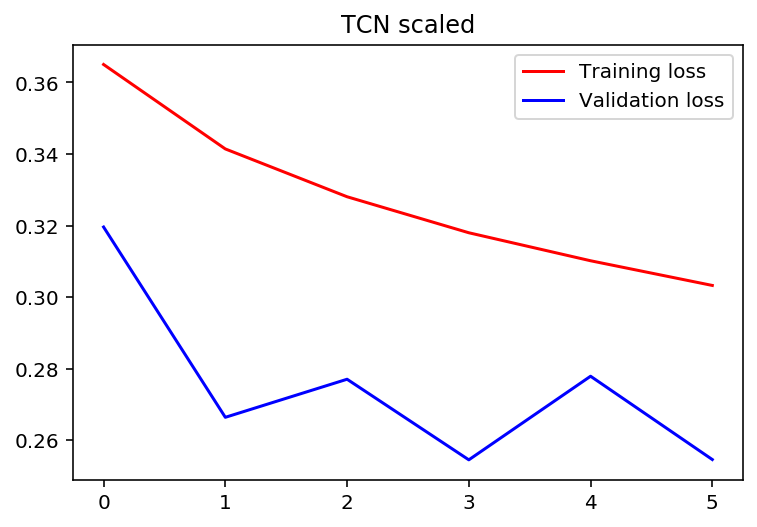

In [72]:
plot_loss(history, 'TCN scaled')

In [74]:
y_predict = model.predict([test_price, test_info]).ravel()
roc_auc_score(test_target, y_predict)

0.9454007140424925

In [75]:
y_class = [1 if p > 0.5 else 0 for p in y_predict]
confusion_matrix(test_target, y_class)

array([[47522,  2519],
       [ 5484, 10726]], dtype=int64)

In [76]:
unique, counts = np.unique(y_class, return_counts=True)
dict(zip(unique, counts))

{0: 53006, 1: 13245}

In [78]:
recall_score(test_target, y_class)

0.6616903146206046

In [79]:
precision_recall_fscore_support(test_target, y_class)

(array([0.89654001, 0.80981502]),
 array([0.94966128, 0.66169031]),
 array([0.92233641, 0.7282974 ]),
 array([50041, 16210], dtype=int64))

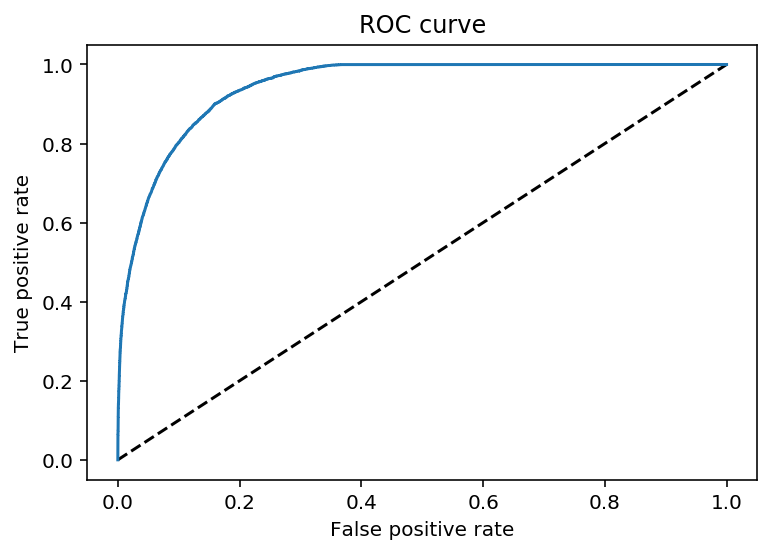

In [81]:
fpr_keras, tpr_keras, thresholds_keras = roc_curve(test_target, y_predict)
auc_keras = auc(fpr_keras, tpr_keras)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.show()

In [83]:
model.save('pledge_company_model.h5')